# Keras Prototype CNN 

I am creating this notebook because I often need to build a Neural Net or CNN in Keras, and spend time looking up little things that I forget. Having all the useful functions in one place where I (or you) can easily copy and paste and adapt into new code is useful, so here you go, future me. 

## Arbitrary Dataset for Testing 

In [1]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [2]:
## extract 0,1 for binary classification 
x_new = x_train.copy()
y_new = y_train.copy()
i = 0
for x,y in zip(x_train, y_train):
    if y<2:
        y_new[i] = y
        x_new[i] = x
        i+= 1
        
y_train = y_new[:i]
x_train = x_new[:i]

## Imports

In [3]:
from keras.models import Sequential 
from keras.layers import Flatten, Dense, Lambda, Dropout, Cropping2D
from keras.regularizers import l2
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import losses
from keras import optimizers 
from keras import metrics 
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

## Within Model Image Processing 

use those lamda functions! 

In [4]:
def resize(img, shape):
    '''resizing within model: 
    -- import module within function to preserve reference when saving/loading
    -- args: input image, shape == [height, width], no color channels (like cv2)
    -- returns: resized image - keras compatable  
    '''
    from keras.backend import tf as ktf
    return ktf.image.resize_images(img,shape)

# ### --- PREPROCESSING WITHIN MODEL --- ####
# model.add(Lambda(lambda x: (x / 127.5) - 1., input_shape = input_shape)) #normalize 
# model.add(Lambda(resize, input_shape=input_shape)) #resize 
# model.add(Cropping2D(cropping=((20, 15), (0, 0)), input_shape = input_shape)) #crop edges

## Build Model 

note input shape may need to be changed as lambda layers are added

In [5]:
model = Sequential()

###--- Convolutional Neural Network --- ### 
input_shape = (32, 32, 3)

### conv. layers ### https://keras.io/layers/convolutional/
model.add(Convolution2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

### fully connect layers 
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(.3))

model.add(Dense(16, activation='relu'))
model.add(Dropout(.3))

#final layer, 
model.add(Dense(1))


# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

## Compile Model

In [6]:
loss = losses.mean_squared_error #binary_crossentropy, categorical_crossentropy
optimizer= optimizers.Adam(lr=0.001, decay=0.0) #SGD
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

## Create Callbacks 

for Model Checkpoints, Early Stopping and Tensorboard Visualizations 

In [7]:
#tensorboard object 
!mkdir logs
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)


#save model at every weight improvement 
# filepath="checkpoints/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#save and overwrite models when improved 
filepath="checkpoints/weights_best.h5"

!mkdir checkpoints
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                             verbose=0, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=3, verbose=0, mode='auto')

callbacks_list = [checkpoint, tensorboard, early_stop]

A subdirectory or file logs already exists.


## Fit Model and Save

In [8]:
history = model.fit(x_train, y_train,
                    validation_split=0.33,
                    epochs=100,
                    callbacks=callbacks_list,
                    verbose=1)

#save final model (redundant with checkpoints)
model.save('model.h5')

Train on 6699 samples, validate on 3301 samples
Epoch 1/100
6699/6699 [==============================] - 23s - loss: 152.8766 - acc: 0.3262 - val_loss: 0.4476 - val_acc: 0.5041
Epoch 2/100
6699/6699 [==============================] - 22s - loss: 0.6752 - acc: 0.4783 - val_loss: 0.4266 - val_acc: 0.5041
Epoch 3/100
6699/6699 [==============================] - 21s - loss: 0.5039 - acc: 0.5090 - val_loss: 0.4173 - val_acc: 0.5041.5
Epoch 4/100
6699/6699 [==============================] - 22s - loss: 0.4245 - acc: 0.5229 - val_loss: 0.4081 - val_acc: 0.5041
Epoch 5/100
6699/6699 [==============================] - 22s - loss: 0.3768 - acc: 0.5275 - val_loss: 0.3938 - val_acc: 0.5041


## Visualize Model Training Inline - Accuracy and Loss

dict_keys(['val_acc', 'acc', 'val_loss', 'loss'])


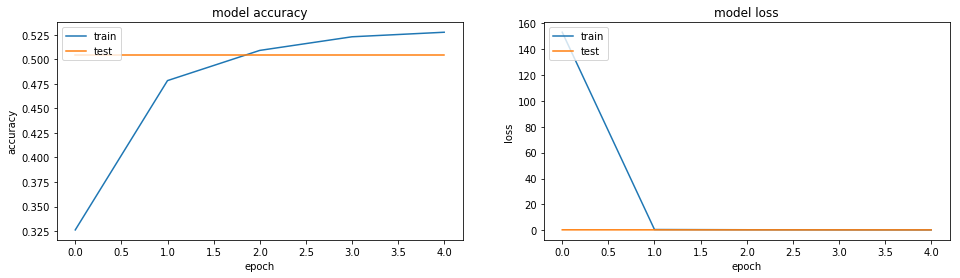

In [9]:
print (history.history.keys())

import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))

# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show(); 

## Tensorboard! 

** for dope ass visualizations type in terminal: **

    tensorboard  --logdir logs/